In [1]:
import numpy
import matplotlib
from matplotlib import pyplot

In [2]:
DATA = """
0.0 85.48754626821457
1.0 83.3374939055901
2.0 81.5529216178601
3.0 81.14965233737591
4.0 81.13650134321668
5.0 81.30486231033403
6.0 81.5736363708307
7.0 81.90427196684664
8.0 82.27577930702309
9.0 82.67559802362508
10.0 83.09568260745094
11.0 83.5306117547507
12.0 83.97658626259017
13.0 84.43085961690434
14.0 84.89139543907528
15.0 85.35665258905902
16.0 85.8254440501482
17.0 86.2968420554337
18.0 86.77011358005892
19.0 87.2446727221866
20.0 87.72004939192425
"""

In [3]:
def make_test():
    locs = []
    values = []
    
    for row in DATA.split("\n"):
        if not row:
            continue
        loc, value = row.split(" ")
        locs.append(float(loc))
        values.append(float(value))
        
    values = -numpy.array(values)
    start = locs[0]
    stop = locs[-1]
    return values, start, stop
    
VALUES, START, STOP = make_test()
VALUES, START, STOP

(array([-85.48754627, -83.33749391, -81.55292162, -81.14965234,
        -81.13650134, -81.30486231, -81.57363637, -81.90427197,
        -82.27577931, -82.67559802, -83.09568261, -83.53061175,
        -83.97658626, -84.43085962, -84.89139544, -85.35665259,
        -85.82544405, -86.29684206, -86.77011358, -87.24467272,
        -87.72004939]),
 0.0,
 20.0)

cdf
0.0
0.000315160719041705
0.026577602616777045
0.0577630439867111
0.13057852142457785
0.29522264131177844
0.9992776373013015
0.9997808941742325
1.0
0.9995970616963257
0.999597306858009
0.9995975518705424


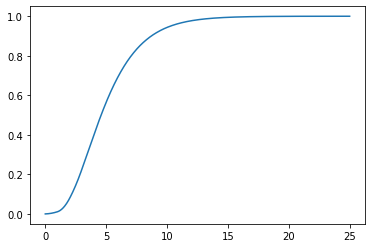

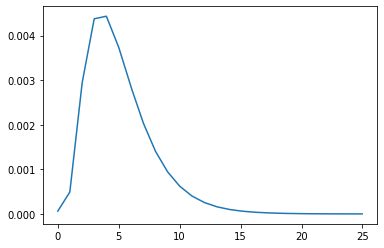

cdf
0.0
9.839079634918341e-05
0.004231945833536049
0.0065703159469343644
0.012175887633071158
0.03511566908393952
0.7409267751169983
0.784330519183644
1.0
0.763601112226576
0.7636227847191358
0.7636444552248126


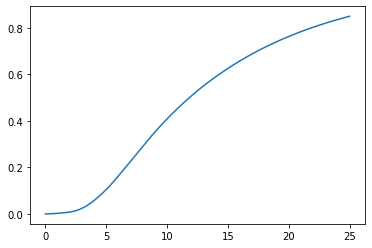

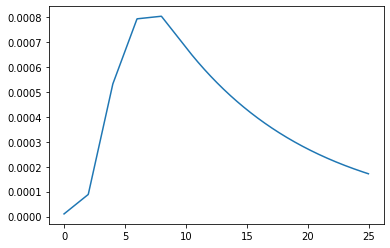

cdf
0.0
0.0002788249485059417
0.019547419992305123
0.042255764639014384
0.09969663693236364
0.23811795107815176
0.9985411510689169
0.9993977905562565
1.0
0.9990622845469384
0.9990626992994277
0.9990631138684717


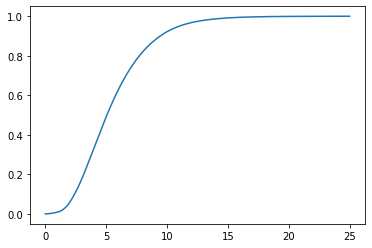

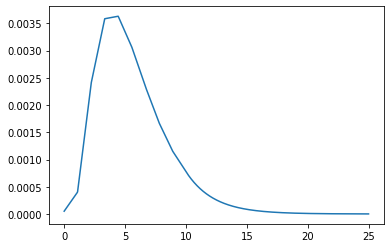

In [4]:
def prior_pwlet(values, start, stop):
    log_rates = values - values.max()
    rates = numpy.exp(log_rates)
    
    # linear bulk
    delta = (stop - start) / (len(rates) - 1)
    masses = 0.5 * (rates[1:] + rates[:-1]) * delta
    
    # exponential tail
    # match gradient, scale, and location
    # (1) f = exp(a - b x); f(stop) = rate(stop)
    # (2) f' = -b f; f'(stop) = d/dx(rate(stop))
    log_rate_stop = log_rates[-1]
    rate_stop = rates[-1]
    rate_dash_stop = (rates[-2] - rate_stop) / delta
    
    # (2) => b = -d/dx(rate(stop)) / rate(stop)
    tail_b = rate_dash_stop / rate_stop
    
    # (1) => a = log(rate(stop)) + b x
    tail_a = log_rate_stop + tail_b * stop

    if not tail_b > 0:
        raise ValueError(tail_b)

    # integrate exp(a - b * x) from end to inf
    # a - b * stop = log(rate_stop)
    tail_mass = rate_stop / tail_b
    
    # normalize and reparameterize
    cmf = numpy.concatenate([[0], numpy.cumsum(masses)])
    norm = 1 / (cmf[-1] + tail_mass)
    
    cmf_norm = cmf * norm
    tail_mass_norm = tail_mass * norm

    def tail_integral(y):
        return norm * (
            numpy.exp(tail_a - tail_b * y)
            - numpy.exp(tail_a - tail_b * stop)
        ) / -tail_b

    tail_c = tail_a + numpy.log(norm / tail_b)
    tail_d = numpy.exp(tail_c - tail_b * stop)
    
    def tail_integral2(y):
        return tail_d - numpy.exp(tail_c - tail_b * y)

    tail_e = cmf_norm[-1] + tail_d
    pdf_norm = rates * norm
    
    def cdf(x):
        indexf = (x - start) / delta
        
        # tail integral
        if not indexf < len(cmf) - 1:
            return tail_e - numpy.exp(tail_c - tail_b * x)

        # piecewise linear
        i = int(indexf)
        frac = indexf - i

        # integrate density in this box, where density linearly increases
        # pdf = pdf_lo + (pdf_hi - pdf_lo) * frac
        pdf_lo = pdf_norm[i]
        pdf_hi = pdf_norm[i + 1]
        mass = delta * frac * (pdf_lo + 0.5 * (pdf_hi - pdf_lo) * frac)

        return cmf_norm[i] + mass
    
    print("cdf")
    print(cdf(0))
    print(cdf(0.1))
    print(cdf(1.4))
    print(cdf(1.8))
    print(cdf(2.4))
    print(cdf(3.4))
    print(cdf(19))
    print(cdf(21))
    print(cdf(1e30))
    print(cdf(20 - 0.001))
    print(cdf(20))
    print(cdf(20 + 0.001))
    xs = numpy.linspace(0., 25., 1000)
    cdfx = numpy.array([cdf(x) for x in xs])
    
    pyplot.plot(xs, cdfx)
    pyplot.show()
    
    pdfx = (cdfx[1:] - cdfx[:-1]) / delta
    pyplot.plot(xs[:-1], pdfx)
    pyplot.show()
    
prior_pwlet(VALUES, START, STOP)
prior_pwlet(VALUES[:6], START, 10)
prior_pwlet(VALUES[:10], START, 10)